Groups and Families
===================

Explore families (determined by last name) and groups (determined by ticket) and how each can impact survivability. Anecdotally, smaller groups seem to do a better job of surviving. This model will explore those features and see how they impact survival prediction.

In [1]:
# set up code and dataframe with training data
import pandas as pd
import numpy as np
import statistics as st

import sklearn.metrics as ms
import sklearn.tree as tr
import sklearn.model_selection as mds

from scipy import interpolate
import matplotlib.pyplot as plt

datestamp = "20250302.160921"
df_ = pd.read_csv(f"../data/kaggle/train.clean.{datestamp}.csv")
print(df_.shape)

(891, 60)


In [2]:
df_sorted_ = df_.sort_values(by=["SurvivorCount", "Ticket"], ascending=False)
df_sorted_frequency = df_sorted_[ df_sorted_[ "SurvivorCount"] < 3 ]
df_sorted_frequency[[ "Survived", "Pclass",  "LastName", "Title", "Ticket", "Cabin", "TicketFrequency", "GroupSize", "SurvivorCount", "GroupSurvived" ]].head(20)

,Survived,Pclass,LastName,Title,Ticket,Cabin,TicketFrequency,GroupSize,SurvivorCount,GroupSurvived
43,1.0,2,Laroche,Miss,SC/Paris 2123,NaN,4,4,2.0,1
608,1.0,2,Laroche,Mrs,SC/Paris 2123,NaN,4,4,2.0,1
685,0.0,2,Laroche,Mr,SC/Paris 2123,NaN,4,4,2.0,1
10,1.0,3,Sandstrom,Miss,PP 9549,G6,3,3,2.0,1
394,1.0,3,Sandstrom,Mrs,PP 9549,G6,3,3,2.0,1
269,1.0,1,Bissette,Miss,PC 17760,C99,4,1,2.0,1
325,1.0,1,Young,Miss,PC 17760,C32,4,1,2.0,1
373,0.0,1,Ringhini,Mr,PC 17760,NaN,4,1,2.0,1
334,1.0,1,Frauenthal,Mrs,PC 17611,NaN,2,2,2.0,1
660,1.0,1,Frauenthal,Dr,PC 17611,NaN,2,3,2.0,1


In [3]:
#all_columns = True
all_columns = False

if all_columns:
    columns_to_drop = [ "Survived", "Name", "Title", "TitleGrouped", "LastName", "Cabin", 
                        "Ticket", "Sex", "Age", "Embarked", "PassengerId", "CabinDeck",
                        "CabinRoom" ]
    columns_to_drop += [ "AgeRobust", "FppRobust", "FppMinMax", "SibSp", "Parch", "SexOrd", 
                         "AgeMinMax" ]
    x_colnames = [i for i in df_.columns if i not in columns_to_drop]
else:
    x_colnames = [ "P3orDeadTitle", "GroupSurvived", "TitleOrd" ]

y_colname = [ "Survived" ]

X = df_[ x_colnames ]
y = df_[ y_colname ].values.ravel()

print(X.info())

# Assuming you have your features in X and your target variable in y
X_train, X_test, y_train, y_test = mds.train_test_split(X, y, test_size=0.2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   P3orDeadTitle  891 non-null    int64  
 1   GroupSurvived  891 non-null    int64  
 2   TitleOrd       891 non-null    float64
dtypes: float64(1), int64(2)
memory usage: 21.0 KB
None


In [4]:
n_folds = 6
s_scoring = "balanced_accuracy"

param_dist = {
    'max_leaf_nodes': [ 3 ],
    'max_depth': [ 2 ],
    'min_samples_split': [ 2 ],
    'min_samples_leaf': [ 1 ]
} 


# Create a decision tree classifier
clf = tr.DecisionTreeClassifier(criterion='entropy')

grid_search = mds.GridSearchCV( estimator=clf,
                                param_grid=param_dist,
                                cv=n_folds,
                                scoring=s_scoring,
                                n_jobs=-1 )

# Train the classifier
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
model       = grid_search.best_estimator_

print(best_params)
print()

{'max_depth': 2, 'max_leaf_nodes': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}



In [5]:
importances = model.feature_importances_
feature_imp_df = pd.DataFrame(
    {'Feature': x_colnames, 'Gini Importance': importances} ).sort_values(
         'Gini Importance', ascending=False)

feature_imp_df.head(5)

,Feature,Gini Importance
0,P3orDeadTitle,0.759237
1,GroupSurvived,0.240763
2,TitleOrd,0.000000


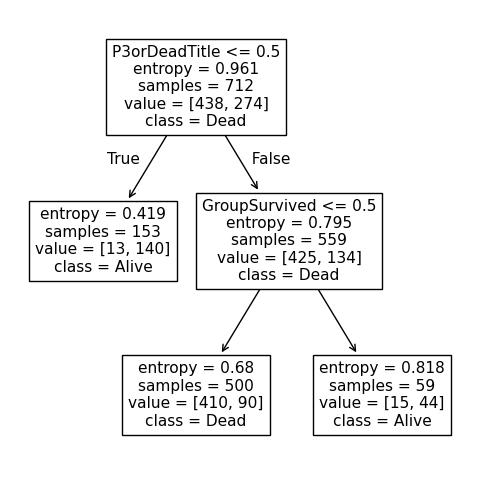

In [6]:
plt.figure(figsize=(6, 6))
tr.plot_tree(model, feature_names=x_colnames, class_names=['Dead', 'Alive'])
plt.show()

In [7]:
y_train_preds_proba = model.predict_proba(X_train)

train_fpr, train_tpr, train_thresh = ms.roc_curve(y_train, y_train_preds_proba[:,1])
train_roc_auc = ms.auc(train_fpr, train_tpr)

# Calculate the geometric mean
gmeans = np.sqrt(train_tpr * (1 - train_fpr))

# Locate the index of the largest gmean
index = np.argmax(gmeans)
train_threshold = train_thresh[index]

train_tpr_intrp = interpolate.interp1d(train_thresh, train_tpr)
train_fpr_intrp = interpolate.interp1d(train_thresh, train_fpr)

print(f"Train AUC {round(train_roc_auc,3)}")
print(f"Train optimal threshold {round(train_threshold,3)} at " \
      f"tpr: {np.round(train_tpr_intrp(train_threshold),3)}, " \
      f"fpr: {np.round(train_fpr_intrp(train_threshold),3)}")

Train AUC 0.81
Train optimal threshold 0.746 at tpr: 0.672, fpr: 0.064


In [8]:
# calculate test ROC curve
y_test_preds_proba  = model.predict_proba(X_test)

test_fpr, test_tpr, test_thresh = ms.roc_curve(y_test, y_test_preds_proba[:,1])
test_roc_auc = ms.auc(test_fpr, test_tpr)

# Calculate the geometric mean
test_gmeans = np.sqrt(test_tpr * (1 - test_fpr))

# Locate the index of the largest gmean
test_index = np.argmax(test_gmeans)
test_threshold = test_thresh[test_index]

test_tpr_intrp = interpolate.interp1d(test_thresh, test_tpr)
test_fpr_intrp = interpolate.interp1d(test_thresh, test_fpr)

print(f"Test AUC {round(test_roc_auc,3)}")
print(f"Test optimal threshold {round(test_threshold,3)} at " \
      f"tpr: {np.round(test_tpr_intrp(test_threshold),3)}, " \
      f"fpr: {np.round(test_fpr_intrp(test_threshold),3)}")

Test AUC 0.805
Test optimal threshold 0.746 at tpr: 0.662, fpr: 0.063


In [9]:
# Define the desired operating point (FPR, TPR)
test_operating_point_fpr = test_fpr_intrp(test_threshold)
test_operating_point_tpr = test_tpr_intrp(test_threshold)

# Find the closest threshold to the desired operating point
distances = (test_fpr - test_operating_point_fpr)**2 + (test_tpr - test_operating_point_tpr)**2
closest_index = distances.argmin()
test_operating_point_threshold = test_thresh[closest_index]

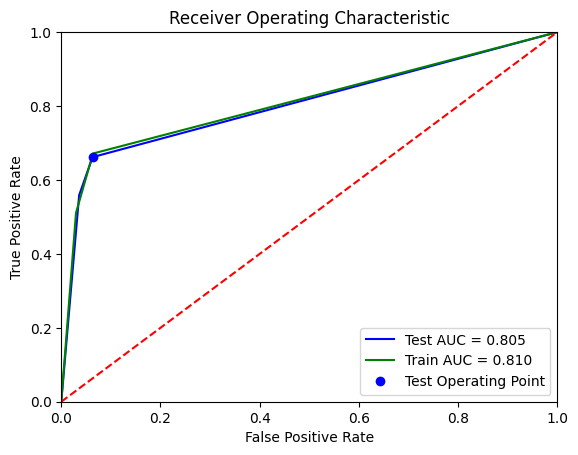

In [10]:
plt.title('Receiver Operating Characteristic')

plt.plot(test_fpr, test_tpr, 'b', label = 'Test AUC = %0.3f' % test_roc_auc)
plt.plot(train_fpr, train_tpr, 'g', label = 'Train AUC = %0.3f' % train_roc_auc)
plt.plot([0, 1], [0, 1],'r--')

plt.plot(test_operating_point_fpr, test_operating_point_tpr, 'bo', label=f'Test Operating Point')
#plt.plot(train_operating_point_fpr,train_operating_point_tpr, 'go', label=f'Train Operating Point')

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc = 'lower right')
plt.show()

In [11]:
print(tr.export_text(model, show_weights=True, feature_names=x_colnames, class_names=['Dead', 'Alive']))

y_test_preds = (y_test_preds_proba[:,1] > test_threshold).astype(int)

tn, fp, fn, tp = ms.confusion_matrix(y_test, y_test_preds).ravel()
print(f"Confusion Matrix, at Threshold {test_threshold:.3f}")
print(f"  tn {tn:<3}  fp {fp:<3}")
print(f"  fn {fn:<3}  tp {tp:<3}")
print()

bal_acc   = round( ms.balanced_accuracy_score( y_test, y_test_preds ), 3 )
precision = round( ms.precision_score( y_test, y_test_preds ), 3 )
recall    = round( ms.recall_score( y_test, y_test_preds ), 3 )
f1        = round( ms.f1_score( y_test, y_test_preds, average='micro' ), 3 )

s_scores = f"Bal Acc: {bal_acc}, Pre: {precision}, Rec: {recall}, F1 Micro: {f1}"
print(s_scores)
print()

l_raw_scores = mds.cross_val_score(model, X_test, y_test, scoring=s_scoring, cv=n_folds)
l_scores = [ round(i, 2) for i in l_raw_scores ]

mean_score = round(st.mean(l_scores), 3)
std_score = round(st.stdev(l_scores), 3)

print(f"{n_folds}-fold {s_scoring} mean: {mean_score}, stdev: {std_score}")
print(f"  each: {l_scores}")

|--- P3orDeadTitle <= 0.50
|   |--- weights: [13.00, 140.00] class: Alive
|--- P3orDeadTitle >  0.50
|   |--- GroupSurvived <= 0.50
|   |   |--- weights: [410.00, 90.00] class: Dead
|   |--- GroupSurvived >  0.50
|   |   |--- weights: [15.00, 44.00] class: Alive

Confusion Matrix, at Threshold 0.746
  tn 107  fp 4  
  fn 30   tp 38 

Bal Acc: 0.761, Pre: 0.905, Rec: 0.559, F1 Micro: 0.81

6-fold balanced_accuracy mean: 0.765, stdev: 0.073
  each: [np.float64(0.68), np.float64(0.82), np.float64(0.72), np.float64(0.76), np.float64(0.88), np.float64(0.73)]


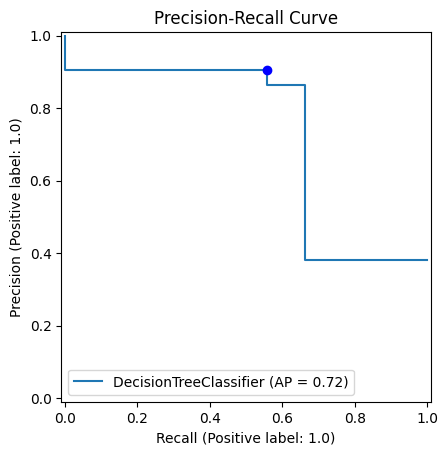

In [12]:
# Plot the precision-recall curve
display = ms.PrecisionRecallDisplay.from_estimator(model, X_test, y_test)
plt.title('Precision-Recall Curve')
plt.plot(recall, precision, 'bo', label=f'Test Operating Point')
plt.show()

In [13]:
df_test = pd.read_csv(f"../data/kaggle/test.clean.{datestamp}.csv")

print(test_threshold)

y_proba = model.predict_proba(df_test[x_colnames])
y_preds = (y_proba[:,1] > test_threshold).astype(int)

df_test["SurvivedProbability"] = y_proba[:,1]
df_test["Survived"] = y_preds

df_test_sub = df_test[ (df_test["SurvivedProbability"] < test_threshold + 0.1) & \
                       (df_test["SurvivedProbability"] > test_threshold - 0.1) ] \
                .sort_values(by="SurvivedProbability") \
                .reset_index()

df_closest = df_test_sub.iloc[(df_test_sub["SurvivedProbability"] - (test_threshold - 0.01) ).abs().argsort()[:100]].sort_values(by="SurvivedProbability")

df_closest[[ "Pclass", "LastName", "Title", "Sex", "Age", "Cabin", "Ticket", "Embarked", "FarePerPerson", "SurvivedProbability", "Survived" ]].style.hide(axis="index")

0.7457627118644068


Pclass,LastName,Title,Sex,Age,Cabin,Ticket,Embarked,FarePerPerson,SurvivedProbability,Survived
2,Caldwell,Mr,male,26.000000,nan,248738,S,9.666700,0.745763,0
3,Asplund,Master,male,5.000000,nan,347077,S,4.483900,0.745763,0
2,Herman,Mr,male,49.000000,nan,220845,S,16.250000,0.745763,0
3,Nakid,Mrs,female,19.000000,nan,2653,C,5.247200,0.745763,0
1,Spencer,Mr,male,57.000000,B78,PC 17569,C,73.260400,0.745763,0
1,Hays,Mr,male,55.000000,B69,12749,S,31.166700,0.745763,0
1,Allison,Mr,male,30.000000,C22 C26,113781,S,37.887500,0.745763,0
1,Spedden,Mr,male,45.000000,E34,16966,C,44.833300,0.745763,0
2,Sweet,Mr,male,14.000000,nan,220845,S,65.000000,0.745763,0
3,Moubarek,Mrs,female,nan,nan,2661,C,5.081900,0.745763,0


In [14]:
df_test[["PassengerId", "Survived"]].to_csv(f"../data/kaggle/submit.families.csv", index=False)